In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import math
import scipy.stats as stats

from random import choices
from trial_1 import Building
from trial_1 import Area
from shapely.geometry import Polygon
from shapely.geometry import box


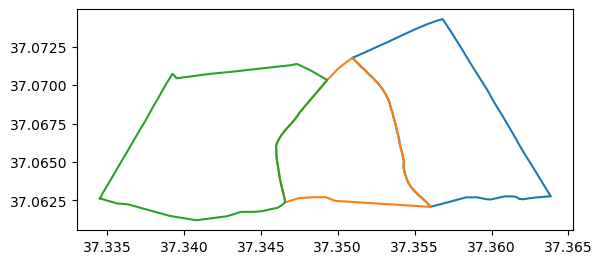

In [2]:
# defines a function which imports multiple areas
def import_areas(addresses):
    areas = []
    areas_gdf = []
    for address in addresses:
        # loads the area as a geodataframe
        area_gdf = ox.geocode_to_gdf(address)
        # area_gdf = area_gdf.to_crs(epsg=32637)
        areas_gdf.append(area_gdf)

        # extracts the area id, name and addresstype
        area_id = area_gdf.loc[0, 'osm_id']
        geometry = area_gdf.loc[0, 'geometry']
        name = area_gdf.loc[0, 'name']
        address = address
        addresstype = area_gdf.loc[0, 'addresstype']

        minx = area_gdf.loc[0, 'bbox_west']
        miny = area_gdf.loc[0, 'bbox_south']
        maxx = area_gdf.loc[0, 'bbox_east']
        maxy = area_gdf.loc[0, 'bbox_north']
        bbox = box(minx, miny, maxx, maxy)

        # creates an area object and appends it to the list
        area = Area(area_id, geometry, bbox, name, address, addresstype)
        areas.append(area)
    return areas, areas_gdf

addresses = ['Sarıgüllük Mahallesi', 'Gazi Mah., Gaziantep', 'Pancarlı Mahallesi']
areas, areas_gdf = import_areas(addresses)

# print(areas[0].geometry.type)
# print(areas_gdf)
# print(areas[0].name, areas[0].area_id, areas[0].addresstype)

fig, ax = plt.subplots()
ax.set_aspect('equal')

for a in areas:
    # Extract the exterior boundary of the area geometry
    polygon = a.geometry.exterior

    # Plot the exterior boundary using Matplotlib
    x, y = polygon.xy
    ax.plot(x, y)  # You can set a specific color

plt.show()

In [3]:
from trial_1 import Earthquake
from functions import assign_building_attributes
from functions import assign_fragility_attributes
from functions import assign_injury_numbers

# input earthquake data: accg, pga, sa03, sa06, sa10, time
Turkey_Feb2023_Quake= Earthquake(9.8, 0.49, 0.98, 0.98, 1.2, 400)

# defines a function which imports all buildings in an area
def import_buildings(area, earthquake):
    # importing osm location
    geometry = area.geometry
    buildings = ox.features.features_from_polygon(geometry, tags={'building': True})
    consolidated_bldgdataframe, bldngs = assign_building_attributes(buildings)
    consolidated_bldgdataframe, medbetatable = assign_fragility_attributes(consolidated_bldgdataframe, bldngs, earthquake)
    partA_data = assign_injury_numbers(consolidated_bldgdataframe, bldngs, medbetatable, earthquake)
    
    # creating object for each building
    bld_lst = []
    for i in partA_data.index:
        id = partA_data.loc[i, 'osmid']
        geo = partA_data.loc[i, 'geometry']
        center_point = geo.centroid
        occupancy_type = partA_data.loc[i, 'occupancytype']
        footprint = partA_data.loc[i, 'Footprint']
        structural_system = partA_data.loc[i, 'structural_system']
        lateral_resistance = partA_data.loc[i, 'lateral_resistance']
        stories = partA_data.loc[i, 'height']
        population_day = partA_data.loc[i, 'population day']
        population_night = partA_data.loc[i, 'population night']
        damage_state_probabilities = [partA_data.loc[i, 'p_ds2'], partA_data.loc[i, 'p_ds3'], partA_data.loc[i, 'p_ds4'], partA_data.loc[i, 'p_ds5']]
        injuries = partA_data.loc[i, 'injuries']

        bld = Building(id, geo, center_point, occupancy_type, footprint, structural_system, lateral_resistance, stories, population_day, population_night, damage_state_probabilities, injuries)
        bld_lst.append(bld)
        area.add_building(bld)

    return bld_lst

no_action = 0
print(areas[0])
for a in areas:
    buildings = import_buildings(a, Turkey_Feb2023_Quake)
    for b in buildings:
        # print(f'building_id: {b.building_id}, occupancy_type: {b.occupancy_type}, footprint: {b.footprint}, structural_system: {b.structural_system}, lateral_resistance: {b.lateral_resistance}, stories: {b.stories}, population_day: {b.population_day}, population_night: {b.population_night}, damage_state_probabilities: {b.damage_state_probabilities}, injuries: {b.injuries}')
        if b.actions == []:
            no_action += 1
        print(f'damage_state: {b.damage_state}, building typology: {b.building_typology}, height code: {b.height_code}, actions: {b.actions}, safe: {b.safe}')
print(f'total buildings: {len(areas[0].buildings)}')
print(f'no_action: {len([building for building in areas[0].buildings if building.safe == True])}')

# area = areas[]
# buildings, area = import_buildings(a, Turkey_Feb2023_Quake)
# for b in buildings:
#     # print(f'building_id: {b.building_id}, occupancy_type: {b.occupancy_type}, footprint: {b.footprint}, structural_system: {b.structural_system}, lateral_resistance: {b.lateral_resistance}, stories: {b.stories}, population_day: {b.population_day}, population_night: {b.population_night}, damage_state_probabilities: {b.damage_state_probabilities}, injuries: {b.injuries}')
#     if b.actions == []:
#         no_action += 1
#     print(f'damage_state: {b.damage_state}, building typology: {b.building_typology}, height code: {b.height_code}, actions: {b.actions}, safe: {b.safe}')
# print(f'total buildings in area object: {len(area.buildings)}')
# print(f'no_action: {no_action}')

damage_state: DS3, building typology: Unreinforced Masonry, height code: HBET:1-3, actions: ['Size-up and Scene Safety', 'Casualty Assessment and Basic Medical Care', 'Shoring and Stabilization (Basic)', 'Safe Access and Egress'], safe: False
damage_state: DS5, building typology: Concrete Frame, Structural Infill, height code: HBET:7-, actions: ['Command and Coordination', 'Multiple Collapse Points', 'Advanced Shoring and Heavy Machinery', 'Urban Search and Rescue (USAR) Techniques', 'Incident Command and Coordination', 'Multiple Casualties and Complex Trench Configurations', 'Technical Trench Rescue', 'Integrate with Other Disciplines', 'Dynamic Environments', 'Rope-Based Confined Space Rescue', 'Advanced Anchoring and Rigging', 'Air Monitoring and Ventilation (Advanced)', 'Complex and Hazardous Incidents', 'Leadership and Incident Command', 'Integration with Other Disciplines', 'High-Risk Scenarios', 'Coordination and Incident Command', 'Integrate with Other Disciplines.1'], safe: Fa

In [4]:
print(f'total buildings a1: {len(areas[0].buildings)}')
print(f'no_action a1: {len([building for building in areas[0].buildings if building.safe == True])}')

print(f'total buildings a1: {len(areas[1].buildings)}')
print(f'no_action a1: {len([building for building in areas[1].buildings if building.safe == True])}')

print(f'total buildings a1: {len(areas[2].buildings)}')
print(f'no_action a1: {len([building for building in areas[2].buildings if building.safe == True])}')

total buildings a1: 407
no_action a1: 146
total buildings a1: 295
no_action a1: 99
total buildings a1: 428
no_action a1: 141


0.08427826958462896 0.19 0 0.7
0.47044219451120206 0.19 0 0.3
0.09187580307953205 0.19 0 0.3
0.5614742575021383 0.19 0.144 0.7
0.4479737214562145 0.19 0.153 0.3
0.1750870928397636 0.19 0 0.7
0.09187580307953205 0.19 0 0.3
0.47044219451120206 0.19 0.05 0.3
0.014440823826322826 0.19 0 0.3
0.1959306755854275 0.19 0 0.3
0.5570305397832863 0.81 0.154 0.7
0.0024700516444598392 0.19 0 0.3
0.11101019935271404 0.19 0 0.3
0.6280510627822944 0.19 0.145 0.3
0.18981155676221084 0.19 0 0.3
0.13377931095769682 0.19 0 0.7
0.075535941668916 0.19 0 0.7
0.28604892805443793 0.19 0 0.3
0.6441658155072714 0.19 0.156 0.3
0.28604892805443793 0.19 0.05 0.7
0.6313313316079479 0.19 0.14 0.3
0.313895004443446 0.19 0.05 0.7
0.44103331246011895 0.81 0.154 0.7
0.6313313316079479 0.19 0.145 0.3
0.009834939827076665 0.19 0.05 0.3
0.09187580307953205 0.19 0 0.3
0.027862016072168518 0.19 0 0.3
0.004301466967549389 0.19 0.05 0.3
0.003097630856063096 0.19 0 0.3
0.027862016072168518 0.19 0 0.3
0.9063714532665421 0.19 0.095

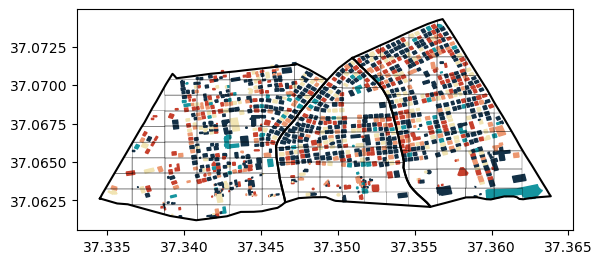

In [5]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area
from trial_1 import Area

# defines a function which generates sub_areas by dividing the boundary of all combined buildings in cells, x_steps = n of cells in x dir, y_steps = n of cells in y dir, and associating buildings with sub_areas
def generate_sub_areas(area, buildings, x_steps, y_steps):
    # set bounds of graph to the bounds of center points
    xmin, ymin, xmax, ymax = area.bbox.bounds
    x_range = xmax - xmin
    y_range = ymax - ymin

    # set stepsize
    width = x_range / x_steps
    height = y_range / y_steps

    # create cols and rows based on bounds and stepsize
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + height, height))

    # sort the list of buildings objects based on x coordinates, then y coordinates
    sorted_blds = sorted(buildings, key=lambda x: (x.center_point.x, x.center_point.y))

    # create cells and plot to graph, add buildings to subarea classes
    sub_areas = []
    i = 0
    j = 0
    for x in cols[:-1]:
        # while the buildings have x values in the range of this column, add them to a list
        filt_blds = []
        while (i < len(sorted_blds)) and (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
            filt_blds.append(sorted_blds[i])
            filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
            i += 1
            
        for y in rows[:-1]:
            # create a cell, sub_area object, and associate the cell with the object
            polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
            sub_area = Sub_Area(j, polygon)
            
            # while the buildings in that column have y values in the range of this row, add them to the cell object 
            while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
                sub_area.add_building(filt_blds.pop(0))

            # only add the sub_area if it has buildings in it
            if sub_area.buildings != []:
                sub_areas.append(sub_area)
            
                # add the sub_areas to the area
                area.add_sub_area(sub_area)

                # crop the geometry of the sub_area with the are geometry
                sub_area.crop_geometry()

                j += 1           
    return sub_areas

# create the sub_areas for each area
for a in areas:
    generate_sub_areas(a, a.buildings, 7, 10)
    for s in a.sub_areas:
        for b in s.buildings:
            b.calculate_priority_weight(b)
        s._update_priority_weight()
    a._update_priority_weight()


# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_geometry(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for a in areas:
        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', linewidth=0.2)
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # choices of different colours with corresponding weights
        # population = ['green', 'blue', 'yellow', 'orange', 'red']
        population = ['#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D']
        weights = [0.45, 0.05, 0.15, 0.12, 0.23]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for g in geos:
            c = choices(population, weights)[0]
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    plt.show()

# show the geometry for each area, sub_area and building
show_geometry(areas)

In [6]:
print(f'building priority weights {[b.injuries[1:] for b in areas[0].buildings]}')
print(f'building priority weights {[b.priority_weight for b in areas[0].buildings]}')
print(f'sub_area priority weights {[s.priority_weight for s in areas[0].sub_areas]}')
print(f'area priority weight {areas[0].priority_weight}')

building priority weights [[5.0, 3.0, 1.0, 1.0], [3592.0, 1768.0, 440.0, 881.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [38.0, 19.0, 5.0, 9.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [3.0, 1.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [2.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [2.0, 1.0, 0.0, 0.0], [14.0, 7.0, 2.0, 3.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [20.0, 10.0, 2.0, 5.0], [0.0, 0.0, 0.0, 0.0], [2.0, 1.0, 0.0, 1.0], [41.0, 20.0, 5.0, 10.0], [31.0, 15.0, 4.0, 8.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [37.0, 18.0, 5.0, 9.0], [3.0, 1.0, 0.0, 1.0], [1.0, 1.0, 0.0, 0.0], [8.0, 3.0, 1.0, 2.0], [3.0, 1.0, 0.0, 1.0], [29.0, 14.0, 3.0, 7.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [5.0, 2.0, 1.0, 1.0], [37.0, 18.0, 4.0, 9.0], [20.0, 10.0, 2.0, 5.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0],

In [7]:
def allocate_teams_to_areas(areas, sector_n_heavy_teams, sector_n_med_teams, sector_n_light_teams, 
                            sector_n_task_force_teams, sector_n_fire_fighter_teams, 
                            sector_n_police_teams, sector_n_volunteer_teams):
    # define the number of people per team
    heavy_n_people = 24
    medium_n_people = 12
    light_n_people = 6
    task_force_n_people = 6
    fire_fighter_n_people = 6
    police_n_people = 6
    volunteer_n_people = 6

    # calculate the total number of people required
    total_people = (heavy_n_people * sector_n_heavy_teams) + (medium_n_people * sector_n_med_teams) + (light_n_people * sector_n_light_teams) + (task_force_n_people * sector_n_task_force_teams) + (fire_fighter_n_people * sector_n_fire_fighter_teams) + (police_n_people * sector_n_police_teams) + (volunteer_n_people * sector_n_volunteer_teams) 
    total_priority = 0
    for a in areas:
        total_priority += a.priority_weight
    
    # calculate the number of people required per priority weight
    people_per_priority = total_people / total_priority

    # calculate the number of people required per area
    for a in areas:
        a.people_requirement = a.priority_weight * people_per_priority

    # sort the areas by people requirement
    sorted_areas = sorted(areas, key=lambda x: (x.people_requirement), reverse=True)

    # reset allocation of teams
    for a in areas:
        a.heavy_teams = 0
        a.med_teams = 0
        a.light_teams = 0
        a.task_force_teams = 0
        a.fire_fighter_teams = 0
        a.police_teams = 0
        a.volunteer_teams = 0

    # allocate teams to areas
    while sector_n_heavy_teams > 0 or sector_n_med_teams > 0 or sector_n_light_teams > 0 or sector_n_task_force_teams > 0 or sector_n_fire_fighter_teams > 0 or sector_n_police_teams > 0 or sector_n_volunteer_teams > 0:
        if sector_n_heavy_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].heavy_teams += 1
            sector_n_heavy_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= heavy_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_med_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].med_teams += 1
            sector_n_med_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= medium_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_light_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].light_teams += 1
            sector_n_light_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= light_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_task_force_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].task_force_teams += 1
            sector_n_task_force_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= task_force_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_fire_fighter_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].fire_fighter_teams += 1
            sector_n_fire_fighter_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= fire_fighter_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_police_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].police_teams += 1
            sector_n_police_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= police_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)   
        elif sector_n_volunteer_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].volunteer_teams += 1
            sector_n_volunteer_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= volunteer_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)                                  
    
# allocate teams to areas based of input of number of teams (heavy, med, light) per sector
allocate_teams_to_areas(areas, 0, 0, 4, 0, 0, 0, 10)
print([[o.heavy_teams, o.med_teams, o.light_teams, o.task_force_teams, o.fire_fighter_teams, o.police_teams, o.volunteer_teams] for o in areas])


[[0, 0, 2, 0, 0, 0, 3], [0, 0, 1, 0, 0, 0, 3], [0, 0, 1, 0, 0, 0, 4]]


In [8]:
from trial_1 import Team
from trial_1 import Sub_Team
from trial_1 import Team_Member
import pandas as pd

# defines a function which creates team, sub-team and team_member objects based on a number of heavy, medium and light teams in an area
def set_teams(heavy, med, light, task_force, fire_fighters, police, volunteer):
    # set number of heavy, medium, light, police, fire_fighters and task_force teams
    n_heavy = heavy
    n_med = med
    n_light = light
    n_police = police
    n_fire_fighters = fire_fighters
    n_task_force = task_force
    n_volunteer = volunteer

    # initialise list of teams and team ids
    teams = []
    team_id = 0
    sub_team_id = 0
    
    # create heavy teams, subteams and teammembers
    for i in range(n_heavy):
        team = Team(team_id, 'heavy')
        for j in range(4):
            sub_team = Sub_Team(sub_team_id, 'heavy')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id,'heavy')       # Create a team member
                sub_team.add_team_member(team_member)                   # Add the team member to the sub-team
                sub_team_member_id += 1                                     # Increment the sub_team_member_id
            sub_team.calculate_action_counts()          # Calculate action counts for the sub-team
            sub_team.calculate_phase1_competence()   # Calculate the phase1_competence for the sub-team
            team.add_sub_team(sub_team)                                 # Add the sub-team to the team
            sub_team_id += 1                                            # Increment the sub_team_id
        teams.append(team)                                              # Add the team to the teams list
        team_id += 1                                                    # Increment the team_id
   
    # create medium teams, subteams and teammembers
    for i in range(n_med):
        team = Team(team_id, 'medium')
        for j in range(4):
            sub_team = Sub_Team(sub_team_id, 'medium')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'medium')       
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()              
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1                                            
        
    # create light teams, subteams and teammembers
    for i in range(n_light):
        team = Team(team_id, 'light')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id, 'light')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'light')      
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()  
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1  

    # create task force team, subteams and teammembers
    for i in range(n_task_force):
        team = Team(team_id, 'task_force')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id, 'task_force')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'task_force')       
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()              
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1         
   
    # create fire_fighters team, subteam and teammembers
    for i in range(n_fire_fighters):
        team = Team(team_id, 'fire_fighter')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id, 'fire_fighter')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'fire_fighter')       
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1 
 
    # create police_team, subteam and teammembers
    for i in range(n_police):
        team = Team(team_id, 'police')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id, 'police')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'police')       
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()  
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1   

    # create volunteer, subteams and teammembers
    for i in range(n_volunteer):
        team = Team(team_id, 'volunteer')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id, 'volunteer')
            sub_team_member_id = 0
            for k in range(6):
                team_member = Team_Member(sub_team_member_id, 'volunteer')       
                sub_team.add_team_member(team_member)           
                sub_team_member_id += 1                             
            sub_team.calculate_action_counts()              
            sub_team.calculate_phase1_competence()   
            team.add_sub_team(sub_team)                         
            sub_team_id += 1                                   
        teams.append(team)                                      
        team_id += 1 

    # Return the 'teams' list after creating all teams
    return teams

In [9]:
area = areas[0]
sub_areas = area.sub_areas

# create the teams
# teams = set_teams(area.heavy_teams, area.med_teams, area.light_teams, 1, 1, 1)
teams = set_teams(area.heavy_teams, area.med_teams, area.light_teams, area.task_force_teams, area.fire_fighter_teams, area.police_teams, area.volunteer_teams)

# defines a function which puts all subteams in multiple teams 
def get_sub_teams(teams):
    # access and create sub_teams list
    sub_teams = []
    for tm in teams:
        for stm in tm.sub_teams:
            sub_teams.append(stm)
    return sub_teams

sub_teams = get_sub_teams(teams)
sub_teams_phase1 = [o for o in sub_teams if o.team_type != 'heavy' and o.team_type != 'medium' and o.team_type != 'light']
sub_team_members = [o.team_members for o in sub_teams]
print([o.team_type for o in sub_teams])
print([o.team_type for o in sub_teams_phase1])

['light', 'light', 'volunteer', 'volunteer', 'volunteer']
['volunteer', 'volunteer', 'volunteer']


In [10]:
# Create lists to store the data
team_ids = [] 
team_class = []
sub_team_ids = []
sub_team_competence = []
num_team_members = []  # List to store the number of team members

# Iterate through the teams and their sub-teams
for team in teams:
    for sub_team in team.sub_teams:
        team_ids.append(team.team_id)
        team_class.append(team.team_type)
        sub_team_ids.append(sub_team.sub_team_id)
        sub_team_competence.append(sub_team.phase1_competence)


# Create a dictionary from the lists
data = {
    'Team_ID': team_ids,
    'Team_Class': team_class,
    'Sub_Team_ID': sub_team_ids, 
    'Phase1_Competence': sub_team_competence
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

   Team_ID Team_Class  Sub_Team_ID  Phase1_Competence
0        0      light            0               25.0
1        1      light            1               17.4
2        2  volunteer            2               12.2
3        3  volunteer            3               12.2
4        4  volunteer            4               12.2


In [11]:
from trial_1 import Sub_Team

# Example: print the weight of a sub-team[] in a team[]
print(f"The phase1 overall competence weight is:", round(teams[0].sub_teams[0].phase1_competence, 2))
print("-" * 30)
# Example: Print the dictionary for the first sub-team in the first heavy team
sub_team = teams[0].sub_teams[0]
# sub_team.calculate_phase1_competence()

# print(f"Sub-team ID: {sub_team.sub_team_id}", f"Sub-team phase1 competence: {sub_team.phase1_competence}", f"Sub-team action counts: {sub_team.action_counts}", sep="\n")

if teams[0].sub_teams[0].action_counts:
    for action, count in teams[0].sub_teams[0].action_counts.items():
        print(f"{action}: {count}")
else:
    print("No actions available for this sub-team.")

The phase1 overall competence weight is: 25.0
------------------------------
Command and Coordination: 1
Multiple Collapse Points: 1
Advanced Shoring and Heavy Machinery: 1
Urban Search and Rescue (USAR) Techniques: 1
Size-up and Scene Safety: 6
Casualty Assessment and Basic Medical Care: 6
Shoring and Stabilization (Basic): 6
Safe Access and Egress: 6
Advanced Scene Assessment: 4
Advanced Medical Care and Triage: 4
Advanced Shoring Techniques: 4
Complex Casualty Extrication: 4
Advanced Hazard Recognition: 3
Advanced Shoring and Trench Box Systems: 1
Casualty Packaging and Extrication: 1
Equipment Operation: 1
Scene Assessment and Safety: 1
Hazard Recognition: 1
Casualty Assessment and Basic Care: 1
Trench Shoring and Stabilization (Basic): 1
Advanced Knot Tying: 4
Complex Rope Systems: 4
Difficult Access: 4
Confined Space Rope Rescue: 4
Knot Tying: 5
Anchor Systems: 5
Ascending and Descending: 5
Rigging and Mechanical Advantage: 5
Advanced Confined Space Entry: 3
Specialized Confined 

In [12]:
# defines a function which allocates sub_team(s) to sub_area(s) based on priority weight and competence, works with sub_teams list or single object
def allocate_sub_team(sub_areas, sub_teams):
    # sorts the sub_areas so that the sub_areas with the highest priority weight are first in the list
    sub_areas = sorted(sub_areas, key=lambda x: (x.priority_weight), reverse=True)

    # links the objects of sub_teams to sub_areas and removes the sub_areas that are allocated from the sub_areas list
    if hasattr(sub_teams, '__iter__'):

        # sorts the sub_teams so that the sub_teams with the highest competence are first in the list
        sub_teams = sorted(sub_teams, key=lambda x: (x.phase1_competence), reverse=True)
        
        # assigns sub_areas to sub_teams
        for i, o in enumerate(sub_teams):
            # filters the sub_areas so that only the sub_areas that haven't been cleared are in the list
            filtered_sub_areas = [sub_area for sub_area in sub_areas if (sub_area.cleared == False)]
            # filters the sub_areas so that only the sub_areas that can be served by the sub_team are in the list
            filtered_sub_areas = [sub_area for sub_area in sub_areas if any((building.damage_state in o.serveable_damage_states and building.cleared == False and building.safe == False) for building in sub_area.buildings)]
            print('-'*30)
            print(f'amount of sub_areas filtered: {len(sub_areas) - len(filtered_sub_areas)}')            

            # Calculate the priority weights for each sub-area only including buildings that are in a damage state that the sub-team can serve
            DS_priority_weights = []
            DS_clear_times = []
            for sub_area in filtered_sub_areas:
                # Initialize a running total for the new priority weight
                new_priority_weight = 0
                new_clear_time = 0

                # Iterate through buildings in the sub_area
                for building in sub_area.buildings:
                    if building.damage_state in o.serveable_damage_states and building.cleared == False and building.safe == False:
                        # Add the building's priority weight to the total
                        new_priority_weight += (building.priority_weight / building.clear_time)
                        new_clear_time += building.clear_time
                DS_priority_weights.append(new_priority_weight)
                DS_clear_times.append(new_clear_time)

            # Pair each sub-area with its DS priority weight
            sub_area_priority_pairs = list(zip(filtered_sub_areas, DS_priority_weights, DS_clear_times))

            # Sort the sub-areas based on DS priority weights
            sorted_sub_areas = [sub_area for sub_area, _, _ in sorted(sub_area_priority_pairs, key=lambda x: x[1], reverse=True)]
            DS_priority_weights = sorted(DS_priority_weights, key=lambda x: x, reverse=True)
            DS_clear_times = [DS_clear_time for _, _, DS_clear_time in sorted(sub_area_priority_pairs, key=lambda x: x[1], reverse=True)] 
            # print(f'sorted_sub_areas: {sorted_sub_areas}')
            # print(f'DS_priority_weights: {DS_priority_weights}')
            # print(f'DS_clear_times: {DS_clear_times}')

            # assign the sub_area to the sub_team
            o.assign_sub_area(sorted_sub_areas[0])
            print(f'sub_team {o.sub_team_id} assigned to sub_area {o.sub_area}')

            o.rem_time -= DS_clear_times[0]
            for building in o.sub_area.buildings:
                if building.damage_state in o.serveable_damage_states and building.cleared == False and building.safe == False:
                    building.set_cleared()
                    # print(f'building {building.building_id} cleared')
                    # print(f'building clear_time: {building.clear_time}')
            if o.sub_area.cleared == True:
                sub_areas.remove(o.sub_area)

            print(f'amount of cleared buildings in area: {len([building for building in sub_areas[0].area.buildings if building.cleared == True])}')
            
    else:
        # filters the sub_areas so that only the sub_areas that haven't been cleared are in the list
        filtered_sub_areas = [sub_area for sub_area in sub_areas if (sub_area.cleared == False)]
        # filters the sub_areas so that only the sub_areas that can be served by the sub_team are in the list
        filtered_sub_areas = [sub_area for sub_area in sub_areas if any((building.damage_state in sub_teams.serveable_damage_states and building.cleared == False and building.safe == False) for building in sub_area.buildings)]
        print('-'*30)
        print(f'amount of sub_areas filtered: {len(sub_areas) - len(filtered_sub_areas)}')            

        # Calculate the priority weights for each sub-area only including buildings that are in a damage state that the sub-team can serve
        DS_priority_weights = []
        DS_clear_times = []
        for sub_area in filtered_sub_areas:
            # Initialize a running total for the new priority weight
            new_priority_weight = 0
            new_clear_time = 0

            # Iterate through buildings in the sub_area
            for building in sub_area.buildings:
                if building.damage_state in sub_teams.serveable_damage_states and building.cleared == False and building.safe == False:
                    # Add the building's priority weight to the total
                    new_priority_weight += (building.priority_weight / building.clear_time)
                    new_clear_time += building.clear_time
            DS_priority_weights.append(new_priority_weight)
            DS_clear_times.append(new_clear_time)

        # Pair each sub-area with its DS priority weight
        sub_area_priority_pairs = list(zip(filtered_sub_areas, DS_priority_weights, DS_clear_times))

        # Sort the sub-areas based on DS priority weights
        sorted_sub_areas = [sub_area for sub_area, _, _ in sorted(sub_area_priority_pairs, key=lambda x: x[1], reverse=True)]
        DS_priority_weights = sorted(DS_priority_weights, key=lambda x: x, reverse=True)
        DS_clear_times = [DS_clear_time for _, _, DS_clear_time in sorted(sub_area_priority_pairs, key=lambda x: x[1], reverse=True)] 
        # print(f'sorted_sub_areas: {sorted_sub_areas}')
        # print(f'DS_priority_weights: {DS_priority_weights}')
        # print(f'DS_clear_times: {DS_clear_times}')

        # assign the sub_area to the sub_team
        if sorted_sub_areas != []:
            sub_teams.assign_sub_area(sorted_sub_areas[0])
            print(f'sub_team {sub_teams.sub_team_id} assigned to sub_area {sub_teams.sub_area}')

            sub_teams.rem_time -= DS_clear_times[0]
            for building in sub_teams.sub_area.buildings:
                if building.damage_state in sub_teams.serveable_damage_states and building.cleared == False and building.safe == False:
                    building.set_cleared()
            if sub_teams.sub_area.cleared == True:
                sub_areas.remove(sub_teams.sub_area)
            print(f'amount of cleared buildings in area: {len([building for building in sub_areas[0].area.buildings if building.cleared == True])}')

        else:
            sub_teams.rem_time = 0
        # sub_teams.assign_sub_area(sub_areas.pop(0))
        # sub_teams.rem_time -= sub_teams.sub_area.clear_time
        # sub_teams.sub_area.cleared = True
    return sub_areas

In [13]:
print([(b.cleared or b.safe) for b in area.sub_areas[0].buildings])
print([(b.cleared) for b in area.sub_areas[0].buildings])
print([(b.safe) for b in area.sub_areas[0].buildings])
print(all([(b.cleared or b.safe) for b in area.sub_areas[0].buildings]))

[False, True]
[False, False]
[False, True]
False


In [14]:
# reset the cleared buildings and remaining time of the sub_teams
for building in area.buildings:
    building.cleared = False
for o in sub_teams_phase1:
    o.rem_time = 1440
    o.sub_area = None
    o.sub_area_priority = None

# print(f'sub_area priority weights: {[o.priority_weight for o in sub_areas]}')
# print(f'sub_team phase 1 competences: {[o.phase1_competence for o in sub_teams]}')
print(f'cleared buildings in area: {len([o for o in area.buildings if o.cleared == True])}')
print(f'rem_time: {[o.rem_time for o in sub_teams_phase1]}')

# allocate all teams during start
rem_sub_areas = allocate_sub_team(sub_areas, sub_teams_phase1)

# sort the sub_teams by remaining time
sorted_sub_teams = sorted(sub_teams_phase1, key=lambda x: (x.rem_time), reverse=True)
print(f'rem_time: {[o.rem_time for o in sorted_sub_teams]}')

# allocate teams while there are sub_areas left and while there are teams with remaining time
while (len(rem_sub_areas) > 0) and any(o.rem_time > 0 for o in sorted_sub_teams):
    rem_sub_areas = allocate_sub_team(rem_sub_areas, sorted_sub_teams[0])
    sorted_sub_teams = sorted(sorted_sub_teams, key=lambda x: (x.rem_time), reverse=True)

print(f'rem_time: {[o.rem_time for o in sorted_sub_teams]}')
# print(f'amount of total sub_areas: {len(sub_areas)}')
# print(f'amount of cleared sub-areas: {len(sub_areas) - len(rem_sub_areas)}')
# print(f'amount of remaining sub_areas: {len(rem_sub_areas)}')
print(f'cleared buildings in area: {len([o for o in area.buildings if o.cleared == True])}')



cleared buildings in area: 0
rem_time: [1440, 1440, 1440]
------------------------------
amount of sub_areas filtered: 9
sub_team 2 assigned to sub_area <trial_1.Sub_Area object at 0x00000265365BD1C0>
amount of cleared buildings in area: 5
------------------------------
amount of sub_areas filtered: 10
sub_team 3 assigned to sub_area <trial_1.Sub_Area object at 0x00000265365BD160>
amount of cleared buildings in area: 9
------------------------------
amount of sub_areas filtered: 11
sub_team 4 assigned to sub_area <trial_1.Sub_Area object at 0x00000265365BD6A0>
amount of cleared buildings in area: 11
rem_time: [1350, 1260, 1215]
------------------------------
amount of sub_areas filtered: 12
sub_team 4 assigned to sub_area <trial_1.Sub_Area object at 0x00000265365BD640>
amount of cleared buildings in area: 15
------------------------------
amount of sub_areas filtered: 13
sub_team 3 assigned to sub_area <trial_1.Sub_Area object at 0x00000265364AE340>
amount of cleared buildings in area:

In [15]:
for sub_team in sub_teams:
    print(f'sub_team {sub_team.sub_team_id} serveable damage states: {sub_team.serveable_damage_states}')

# check what sub_areas and buildings are cleared
cleared_blds = 0
for sub_area in sub_areas:
    if any(o.cleared == True for o in sub_area.buildings):
        dmg_states = [o.damage_state for o in sub_area.buildings if o.cleared == True]
        print(f'sub_area {sub_area.sub_area_id} damage states: {dmg_states}')
        cleared_blds += len(dmg_states)
print(f'cleared buildings in area: {cleared_blds}')

sub_team 0 serveable damage states: ['DS1', 'DS2', 'DS3', 'DS4', 'DS5']
sub_team 1 serveable damage states: ['DS1', 'DS2', 'DS3', 'DS4', 'DS5']
sub_team 2 serveable damage states: ['DS1', 'DS2']
sub_team 3 serveable damage states: ['DS1', 'DS2']
sub_team 4 serveable damage states: ['DS1', 'DS2']
sub_area 0 damage states: ['DS2']
sub_area 1 damage states: ['DS2']
sub_area 2 damage states: ['DS2', 'DS2', 'DS2']
sub_area 4 damage states: ['DS2']
sub_area 5 damage states: ['DS2', 'DS2']
sub_area 6 damage states: ['DS2', 'DS2']
sub_area 7 damage states: ['DS2', 'DS2', 'DS2']
sub_area 8 damage states: ['DS2', 'DS2', 'DS2', 'DS2']
sub_area 9 damage states: ['DS2', 'DS2', 'DS2']
sub_area 10 damage states: ['DS2']
sub_area 11 damage states: ['DS2']
sub_area 12 damage states: ['DS2']
sub_area 13 damage states: ['DS2', 'DS2']
sub_area 15 damage states: ['DS2', 'DS2']
sub_area 16 damage states: ['DS2']
sub_area 17 damage states: ['DS2', 'DS2', 'DS2']
sub_area 18 damage states: ['DS2']
sub_area 19 

In [16]:
print(len(sub_areas))
print(len(sub_teams))
print(sub_teams)

42
5
[<trial_1.Sub_Team object at 0x000002653677D250>, <trial_1.Sub_Team object at 0x00000265365916D0>, <trial_1.Sub_Team object at 0x0000026536591CA0>, <trial_1.Sub_Team object at 0x0000026536591D90>, <trial_1.Sub_Team object at 0x0000026536591880>]


In [17]:
import math
import itertools

def allocate_sub_team_p2(sub_areas, sub_teams):
    # allocation of sub_teams in an area to sub_areas phase 2
    total_action_count_list = []
    
    for s in sub_teams:
        # filters the sub_areas so that only the sub_areas that haven't been cleared are in the list
        filtered_sub_areas = [sub_area for sub_area in sub_areas if (sub_area.cleared == False)]
        # filters the sub_areas so that only the sub_areas that can be served by the sub_team are in the list
        filtered_sub_areas = [sub_area for sub_area in sub_areas if any((building.damage_state in s.serveable_damage_states and building.cleared == False and building.safe == False) for building in sub_area.buildings)]
        
        # print('-'*30)
        # print(f'amount of sub_areas filtered: {len(sub_areas) - len(filtered_sub_areas)}') 
        
        # create empty dictionary to store the serveable sub_areas and their priority weights
        serveable_sub_areas = {}
        serveable_buildings = {}
        # sub_areas_priorities = []
        # print(f'sub_team.action_counts: {s.action_counts}')
        # filter the sub_areas list to only include sub_areas that have not been cleared and that have required actions that the sub_team can perform
        for sa in filtered_sub_areas:
            # check if the sub_team has the available actions required to clear the sub_area
            if (all(required_action in s.action_counts for required_action in sa.required_actions)) and (sa.cleared == False):
                # create priority weights for each sub_area based on the criteria and how well the required actions match the available actions
                # adding up all the counts of people who can perform each required action
                total_action_count = 0
                for required_action in sa.required_actions:
                    total_action_count += s.action_counts[required_action]
                
                # creating a factor based on the total_action_count, to multiply the estimated time with
                sub_team_efficiency = 1.5 * (1 - math.exp(- (0.0193 * total_action_count))) + 0.5

                # Initialize a running total for the new priority weight
                new_priority_weight = 0
                new_clear_time = 0

                
                # Iterate through buildings in the sub_area
                for building in sa.buildings:
                    if building.damage_state in s.serveable_damage_states and building.cleared == False and building.safe == False:
                        # Add the building's priority weight to the total
                        new_priority_weight += (building.priority_weight / building.clear_time)
                        new_clear_time += building.clear_time
                        factored_building_priority_weight = (building.priority_weight / building.clear_time) * sub_team_efficiency
                        serveable_buildings[building] = factored_building_priority_weight

                DS_priority_weight = new_priority_weight
                
                # creating the factored priority weight
                factored_priority_weight = DS_priority_weight * sub_team_efficiency
                serveable_sub_areas[sa] = factored_priority_weight
                

                total_action_count_list.append(total_action_count)

                # print('sub_team_actions:', s.action_counts.keys())
                # print('sub_area_req_actions:', sa.required_actions)
                # print('total_action_count:', total_action_count)
                # print('clear_time:', sa.clear_time)
                # print('priority_weight:', sa.priority_weight)
                # print('sum_building_weights:', sa.clear_time * sa.priority_weight)
                # print('sub_team_efficiency:', sub_team_efficiency)
                # print('factored_clear_time:', sa.priority_weight / sub_team_efficiency)
                # print('factored_priority_weight:', factored_priority_weight)
        
        serveable_sub_areas = sorted(serveable_sub_areas.items(), key=lambda x: (x[1]), reverse=True)
        s.serveable_sub_areas = serveable_sub_areas
        s.serveable_buildings = serveable_buildings
        print(f'serveable_sub_areas: {serveable_sub_areas}')

    if len(sub_teams) > 1:
        # slice the serveable_sub_areas dictionary to the amount of subteams in the area
        sliced_sub_areas = [dict(itertools.islice(o.serveable_sub_areas, len(sub_teams))) for o in sub_teams]
        print('sliced_sub_areas:', sliced_sub_areas)
        
        # create the option for no sub_area to be assigned to a sub_team
        for i, sub_area_list in enumerate(sliced_sub_areas):
            sub_area_list[None] = 0

        # Create an empty list to store all combinations
        all_combinations = []

        # Calculate the Cartesian product of serveable sub-areas for each sub-team
        for combination in itertools.product(*sliced_sub_areas):
            # append combination to all_combinations, 'combination' is a list sub_area objects
            all_combinations.append(combination)
        print(all_combinations)
        # Filter any combinations that contain duplicate sub-areas
        filtered_combinations = list(filter(lambda x: len(list([sub_area for sub_area in x if sub_area != None])) <= len(set(sub_area for sub_area in x)), all_combinations))
        print('amount of combinations:', len(all_combinations),
            '\namount of combinations after filtering:', len(filtered_combinations), 
            '\namount of filtered combinations:', ((len(all_combinations)) - (len(filtered_combinations))))
        print('filtered_combinations:', filtered_combinations)
        
        # Associating the sub_area objects with their priority weights and finding the highest priority combination
        best_combination_score = 0
        best_combination = None

        for i, combination in enumerate(filtered_combinations):
            combination_score = 0
            print(f"Combination {i}:")
            for j, sub_area in enumerate(combination):
                priority = sliced_sub_areas[j][sub_area] # Access the sub-area object and priority
                print(f"Sub-area: {sub_area}, Priority: {priority}")
                combination_score += priority
            print(f"Combination score: {combination_score}")
            if combination_score >= best_combination_score:
                best_combination_score = combination_score
                best_combination = combination

        # Getting priority weights for the best combination
        print(f"Best combination score: {best_combination_score}")
        for i, sub_area in enumerate(best_combination):
                priority = sliced_sub_areas[i][sub_area] # Access the sub-area object and priority
                print(f"Sub-area: {sub_area}, Priority: {priority}")
                if sub_area != None:
                    sub_teams[i].assign_sub_area(sub_area)
                    sub_teams[i].sub_area_priority = priority
                    for building in sub_teams[i].sub_area.buildings:
                        if building.damage_state in sub_teams[i].serveable_damage_states and building.cleared == False and building.safe == False:
                            building.set_cleared()
                else:
                    sub_teams[i].assign_sub_area(None)
                    sub_teams[i].sub_area_priority = 0
    else:
        # Assign sub_teams to sub_areas
        sub_teams[0].assign_sub_area(sub_teams[0].serveable_sub_areas[0][0])
        sub_teams[0].sub_area_priority = sub_teams[0].serveable_sub_areas[0][1]
        for building in sub_teams[0].sub_area.buildings:
            if building.damage_state in sub_teams[0].serveable_damage_states and building.cleared == False and building.safe == False:
                building.set_cleared()

    # total_action_count_median = np.median(total_action_count_list)
    # total_action_count_average = np.average(total_action_count_list)
    # print('total_action_count_median:', total_action_count_median)
    # print('total_action_count_average:', total_action_count_average)
    
allocate_sub_team_p2(sub_areas, sub_teams)
print(f'allocated sub_areas: {[o.sub_area for o in sub_teams]}')
print(f'sub_area_priorities: {[o.sub_area_priority for o in sub_teams]}')

serveable_sub_areas: [(<trial_1.Sub_Area object at 0x00000265365BD4C0>, 0.05571174460887602), (<trial_1.Sub_Area object at 0x00000265365BD1F0>, 0.05565538822190431), (<trial_1.Sub_Area object at 0x00000265365BD610>, 0.05181961676250631), (<trial_1.Sub_Area object at 0x00000265365BD070>, 0.048593219294679996), (<trial_1.Sub_Area object at 0x00000265365BD640>, 0.0480835885663001), (<trial_1.Sub_Area object at 0x00000265364AE340>, 0.04485199490580554), (<trial_1.Sub_Area object at 0x00000265365BD0A0>, 0.03820744421725408), (<trial_1.Sub_Area object at 0x00000265365BD130>, 0.037080320911290716), (<trial_1.Sub_Area object at 0x00000265365BD6A0>, 0.03539669690027524), (<trial_1.Sub_Area object at 0x00000265365BD670>, 0.025440819437963873), (<trial_1.Sub_Area object at 0x00000265365BD790>, 0.021203146948908572), (<trial_1.Sub_Area object at 0x00000265365BD1C0>, 0.02115747029345515), (<trial_1.Sub_Area object at 0x00000265364AEBE0>, 0.017763393349827412), (<trial_1.Sub_Area object at 0x0000026

In [18]:
print(f'total buildings a0: {len(area.buildings)}')
print(f'safe buildings a0: {len([building for building in area.buildings if building.safe == True])}')
print(f'cleared buildings a0: {len([building for building in area.buildings if building.cleared == True])}')

print(f'total buildings a1: {len(areas[1].buildings)}')
print(f'safe buildings a1: {len([building for building in areas[1].buildings if building.safe == True])}')
print(f'cleared buildings a1: {len([building for building in areas[1].buildings if building.cleared == True])}')

print(f'total buildings a2: {len(areas[2].buildings)}')
print(f'safe buildings a2: {len([building for building in areas[2].buildings if building.safe == True])}')
print(f'cleared buildings a2: {len([building for building in areas[2].buildings if building.cleared == True])}')

total buildings a0: 407
safe buildings a0: 146
cleared buildings a0: 70
total buildings a1: 295
safe buildings a1: 99
cleared buildings a1: 0
total buildings a2: 428
safe buildings a2: 141
cleared buildings a2: 0


In [19]:
# import relevant libraries
import math
import random
from typing import List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [30]:
# Convert the building data into a list of dictionaries
sub_area = sub_areas[23]
sub_team = sub_teams[0]
team_assigned = sub_team.team_type
buildings = []
for i, b in enumerate(sub_area.buildings):
    building = {
        'Building_Id': sub_area.buildings.index(b),
        'Damage_State': int(re.search(r'\d+', b.damage_state).group()),
        'Building_Height': b.stories,
        'Building_Area': int(b.footprint),
        'Injury_Severity': [int(i) for i in b.injuries[1:]],
    }
    buildings.append(building)
print(buildings)
print(team_assigned)

[{'Building_Id': 0, 'Damage_State': 3, 'Building_Height': 1, 'Building_Area': 551, 'Injury_Severity': [2, 1, 0, 0]}, {'Building_Id': 1, 'Damage_State': 3, 'Building_Height': 2, 'Building_Area': 894, 'Injury_Severity': [6, 3, 1, 1]}, {'Building_Id': 2, 'Damage_State': 2, 'Building_Height': 2, 'Building_Area': 395, 'Injury_Severity': [0, 0, 0, 0]}, {'Building_Id': 3, 'Damage_State': 3, 'Building_Height': 1, 'Building_Area': 390, 'Injury_Severity': [1, 1, 0, 0]}, {'Building_Id': 4, 'Damage_State': 2, 'Building_Height': 1, 'Building_Area': 377, 'Injury_Severity': [0, 0, 0, 0]}, {'Building_Id': 5, 'Damage_State': 2, 'Building_Height': 10, 'Building_Area': 496, 'Injury_Severity': [1, 0, 0, 0]}, {'Building_Id': 6, 'Damage_State': 3, 'Building_Height': 5, 'Building_Area': 475, 'Injury_Severity': [5, 2, 1, 1]}, {'Building_Id': 7, 'Damage_State': 5, 'Building_Height': 4, 'Building_Area': 363, 'Injury_Severity': [28, 14, 3, 7]}, {'Building_Id': 8, 'Damage_State': 3, 'Building_Height': 6, 'Buildin

{0: 1.9382, 1: 2.2496, 2: 1.8295, 3: 1.9258, 4: 1.5381, 5: 3.0612, 6: 2.7979, 7: 3.3968, 8: 2.9414, 9: 2.6247, 10: 3.2035, 11: 1.9288, 12: 2.2159, 13: 1.9305, 14: 3.437}


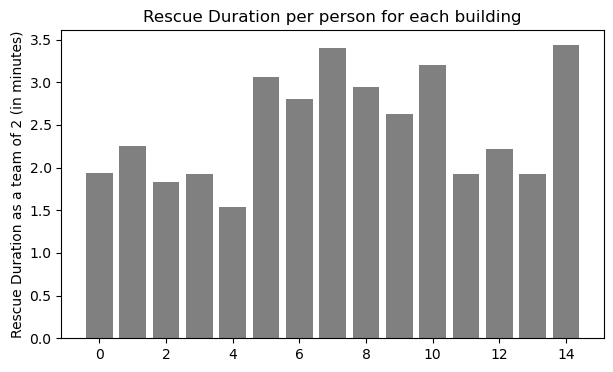

In [31]:
from functions import Rescue_Duration

# Calculate the duration of to save one life for each building and create a dictionary for it
Rescue_duration = Rescue_Duration(buildings, sub_team)
print(Rescue_duration)

# extract the values from the dictionary
building_ids = list(Rescue_duration.keys())
rescue_durations = list(Rescue_duration.values())

# change aspect ratio of the plot
plt.figure(figsize=(7, 4))

# create a bar chart of building vs rescue duration
plt.bar(building_ids, rescue_durations, color='grey')

# show all building ids on the x-axis
# plt.xticks(building_ids)

# label the axes
plt.ylabel('Rescue Duration as a team of 2 (in minutes)')
# plt.xlabel('Building IDs')
plt.title('Rescue Duration per person for each building')

plt.show()

In [32]:
from functions import generate_building_sequences

# create number of sequences that you want to iterate over
num_simulations = 5000
sequences = generate_building_sequences(buildings, num_simulations)

In [35]:
from functions import calculate_rescue_time, calculate_score

# Initialize best scores, sequences, total rescue, and total rescue time variables
best_scores = []
best_sequences = []
total_rescue = []
total_rescue_time = []  # Initialize as an empty list

# Run the simulations using the generated sequences
for sequence in sequences:
    current_time = 0    # Reset the current_time for each sequence
    sequence_scores = 0    # Reset the score for each sequence
    sequence_building_data = []

    # Initialize variables to store cumulative results for all injury classes
    all_initial_people_counts = []
    all_people_alive = []
    all_total_rescued = 0
    all_total_rescue_time = 0

    for building in sequence:
        initial_people_counts, people_alive, total_rescued, rescue_time, current_time = calculate_rescue_time(building,
                                                                                                                    current_time,
                                                                                                                    Rescue_duration=Rescue_duration,
                                                                                                                    buffer_time=20)

        # Accumulate results for all injury classes
        all_initial_people_counts.append(initial_people_counts)
        all_people_alive.append(people_alive)
        all_total_rescued += total_rescued
        all_total_rescue_time += rescue_time

        # Calculate the score for the building and add it to the sequence_scores
        building_score = calculate_score(initial_people_counts, people_alive)
        sequence_scores += building_score

        # Append building data for the sequence
        sequence_building_data.append({
            "Building_ID": building["Building_Id"],
            "Initial_People_Count": initial_people_counts,
            "People_Alive": people_alive,
            "Total_Rescued": total_rescued,
            "Total_Rescue_Time": rescue_time
        })

    # Add the sequence and its score to the list of best sequences
    best_scores.append(sequence_scores)
    best_sequences.append(sequence_building_data)
    total_rescue.append(all_total_rescued)
    total_rescue_time.append(all_total_rescue_time)

# Sort the sequences and scores based on scores (in descending order)
sorted_data = sorted(zip(best_sequences, best_scores), key=lambda x: x[1], reverse=True)

# Print the top 5 sequences and their scores, total rescue, and total rescue time
top_5_sequences = sorted_data[:5]

for i, (sequence, score) in enumerate(top_5_sequences, start=1):
    print(f"Top {i} Sequence Score: {score}")
    print(f"Total Rescued: {total_rescue[i - 1]}")
    print(f"Total Rescue Time: {total_rescue_time[i - 1]}")  # Access the corresponding total rescue time
#     print("Sequence:")

    for building_data in sequence:
        print(f"  Building ID: {building_data['Building_ID']}")
        print(f"  Initial People Count: {building_data['Initial_People_Count']}")
        print(f"  Rescue distribution: {building_data['People_Alive']}")
        print(f"  Total Rescued: {building_data['Total_Rescued']}")
        print(f"  Total Rescue Time (in minutes): {building_data['Total_Rescue_Time']}")
        print('-' * 20)

    print('-' * 40)

Top 1 Sequence Score: 128.5
Total Rescued: 67
Total Rescue Time: 387
  Building ID: 10
  Initial People Count: [15, 7, 2, 4]
  Rescue distribution: [9, 5, 1, 3]
  Total Rescued: 18
  Total Rescue Time (in minutes): 77
--------------------
  Building ID: 14
  Initial People Count: [6, 2, 1, 1]
  Rescue distribution: [3, 1, 0, 0]
  Total Rescued: 4
  Total Rescue Time (in minutes): 33
--------------------
  Building ID: 13
  Initial People Count: [0, 0, 0, 0]
  Rescue distribution: [0, 0, 0, 0]
  Total Rescued: 0
  Total Rescue Time (in minutes): 0
--------------------
  Building ID: 7
  Initial People Count: [28, 14, 3, 7]
  Rescue distribution: [16, 10, 2, 6]
  Total Rescued: 34
  Total Rescue Time (in minutes): 135
--------------------
  Building ID: 6
  Initial People Count: [5, 2, 1, 1]
  Rescue distribution: [2, 1, 0, 0]
  Total Rescued: 3
  Total Rescue Time (in minutes): 28
--------------------
  Building ID: 1
  Initial People Count: [6, 3, 1, 1]
  Rescue distribution: [3, 2, 0,

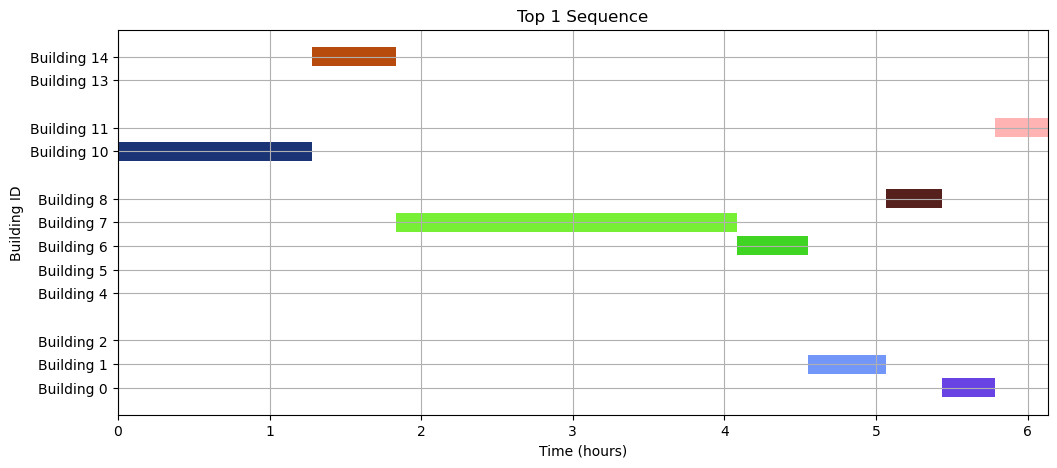

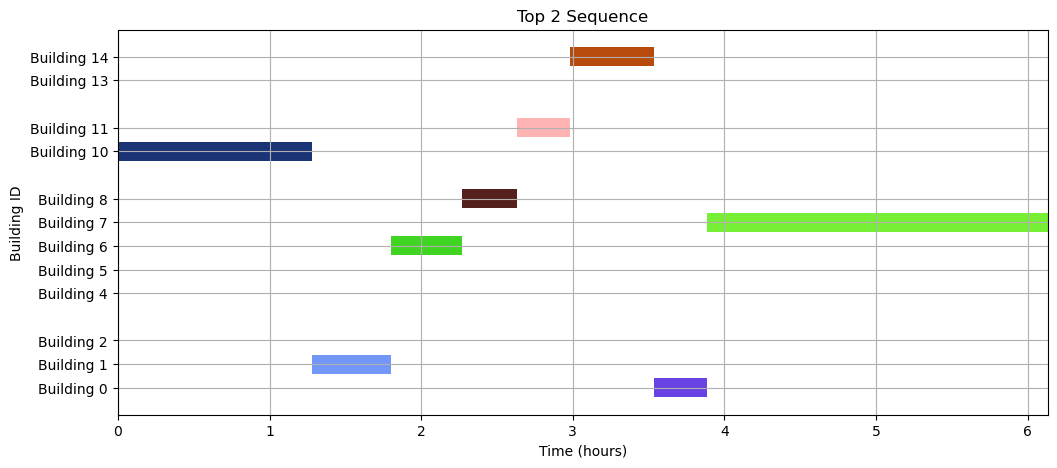

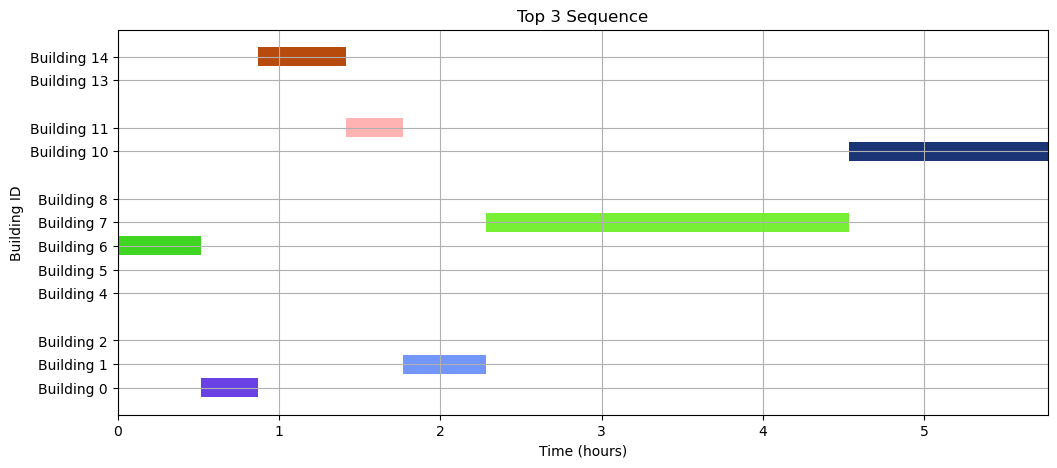

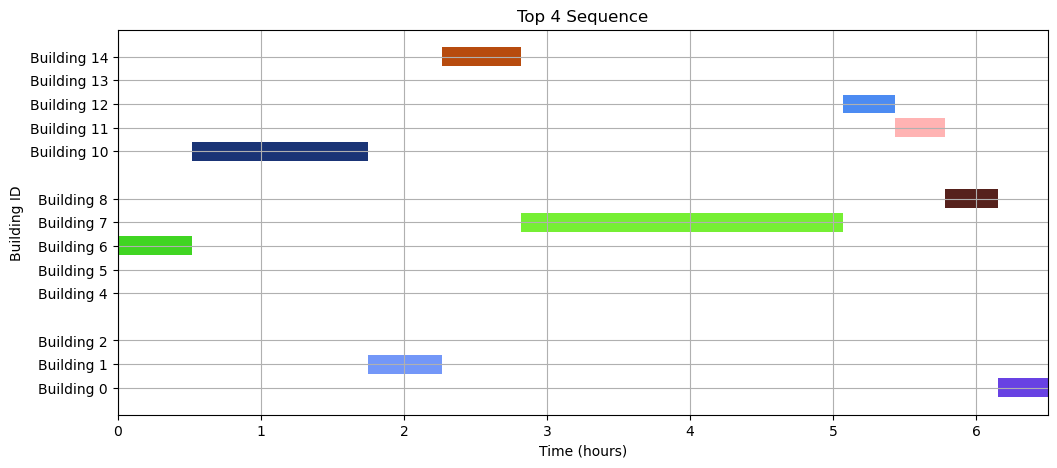

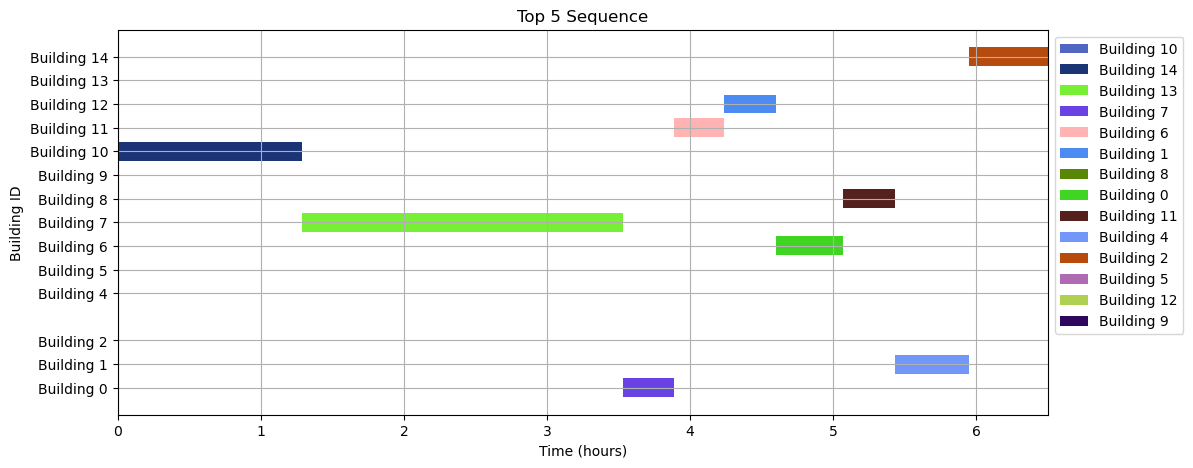

In [40]:
# Initialize a dictionary to keep track of building labels and their colors
building_colors = {}
legend_labels = {}

# Create a Gantt chart for each of the top 5 sequences
for i, (sequence, _) in enumerate(top_5_sequences, start=1):
    plt.figure(figsize=(12, 5))
    plt.title(f"Top {i} Sequence")

    current_time = 0  # Initialize current time in minutes
    for j, building_data in enumerate(sequence):
        building_id = building_data['Building_ID']
        initial_people_count = building_data['Initial_People_Count']
        rescue_time = building_data['Total_Rescue_Time']

        if building_id not in building_colors:
            # Generate a random color for each building
            building_colors[building_id] = "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

        if building_id not in legend_labels:
            legend_labels[building_id] = f"Building {building_id}"

        # Plot the Gantt bar for each building with its unique color
        plt.barh(building_id, rescue_time, left=current_time, label=legend_labels[building_id], color=building_colors[building_id])

        # Update current time for the next building
        current_time += rescue_time

    # Customize the x-axis to display building IDs
    plt.yticks(list(legend_labels.keys()), list(legend_labels.values()))

    # Customize the y-axis to display time in hours
    plt.ylabel("Building ID")
    
    # Customize the x-axis to display time in hours
    plt.xlabel("Time (hours)")
    x_ticks = [i * 60 for i in range(int(current_time / 60) + 1)]  # Convert to hours (1 hour = 60 minutes)
    x_labels = [str(int(t / 60)) for t in x_ticks]
    plt.xticks(x_ticks, x_labels)

    # Show the Gantt chart
    plt.grid(True)

# Create a common legend for all sequences at the end and position it outside
legend_labels_list = list(legend_labels.values())
plt.legend(legend_labels_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

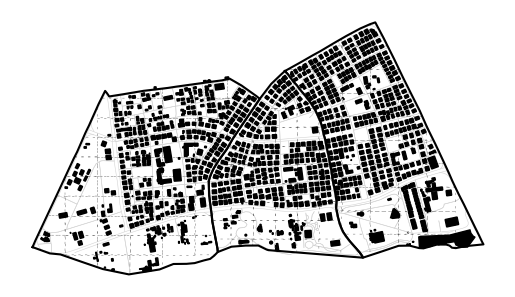

In [77]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_all_geometry(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()

    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D', '#D3D3D3'
    for a in areas:
        network = ox.graph_from_polygon(a.geometry, network_type='all')
        nodes, edges = ox.graph_to_gdfs(network)
        network_gdf = edges.to_crs('EPSG:4326')

        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")
        
        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            c = 'black'
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    fig.savefig('images/all_geometry.png', dpi=300)
    plt.show()
    # print(f'safe_count: {safe_count}')

# show the geometry for each area, sub_area and building
show_all_geometry(areas)


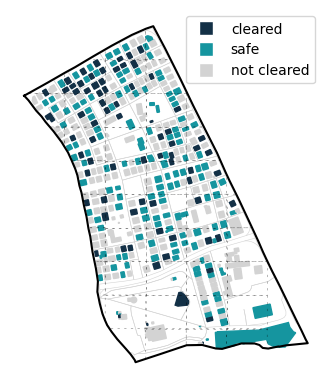

amount of buildings in area: 407


In [78]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

network = ox.graph_from_polygon(area.geometry, network_type='all')
nodes, edges = ox.graph_to_gdfs(network)
network_gdf = edges.to_crs('EPSG:4326')

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_cleared_buildings(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()

    # create legend
    legend_elements = [
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize='10', label='cleared'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize='10', label='safe'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize='10', label='not cleared'),
    ]

    # add legend to graph
    ax.legend(handles=legend_elements, loc='upper right')

    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D', '#D3D3D3'
    for a in areas:
        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")
        
        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            if a.buildings[i].cleared == True:
                c = '#133046'
            elif a.buildings[i].safe == True:
                c = '#15959F'
            else:
                c = '#D3D3D3'
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    fig.savefig('images/buildings_cleared.png', dpi=300)
    plt.show()
    # print(f'safe_count: {safe_count}')

# show the geometry for each area, sub_area and building
show_cleared_buildings([area])

print(f'amount of buildings in area: {len(area.buildings)}')

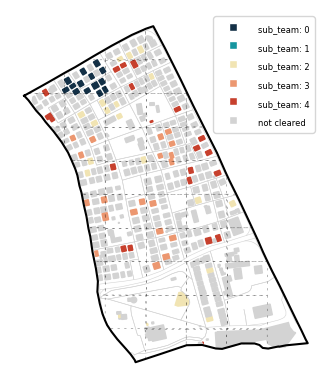

amount of buildings in area: 407
amount of sub_teams: 5
sub_teams: [<trial_1.Sub_Team object at 0x000002221B6EFEB0>, <trial_1.Sub_Team object at 0x000002221B8E1490>, <trial_1.Sub_Team object at 0x000002221B8E1790>, <trial_1.Sub_Team object at 0x000002221B8E1A90>, <trial_1.Sub_Team object at 0x000002221B8E1E20>]


In [52]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_cleared_by(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots(dpi=100)
    ax.set_aspect('equal')

    # create legend
    marker_size = '6'
    if len(sub_teams) > 0:
        legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize=marker_size, label='sub_team: '+str(sub_teams[0].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize=marker_size, label='not cleared'),
        ]
    if len(sub_teams) > 1:
        legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize=marker_size, label='sub_team: '+str(sub_teams[0].sub_team_id)),        
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize=marker_size, label='sub_team: '+str(sub_teams[1].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize=marker_size, label='not cleared'),
        ]
    if len(sub_teams) > 2:        
        legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize=marker_size, label='sub_team: '+str(sub_teams[0].sub_team_id)),        
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize=marker_size, label='sub_team: '+str(sub_teams[1].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize=marker_size, label='sub_team: '+str(sub_teams[2].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize=marker_size, label='not cleared'),
        ]
    if len(sub_teams) > 3:
        legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize=marker_size, label='sub_team: '+str(sub_teams[0].sub_team_id)),        
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize=marker_size, label='sub_team: '+str(sub_teams[1].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize=marker_size, label='sub_team: '+str(sub_teams[2].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#EC9770', markersize=marker_size, label='sub_team: '+str(sub_teams[3].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize=marker_size, label='not cleared'),
        ]
    if len(sub_teams) > 4:
        legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize=marker_size, label='sub_team: '+str(sub_teams[0].sub_team_id)),        
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize=marker_size, label='sub_team: '+str(sub_teams[1].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize=marker_size, label='sub_team: '+str(sub_teams[2].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#EC9770', markersize=marker_size, label='sub_team: '+str(sub_teams[3].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#C7402D', markersize=marker_size, label='sub_team: '+str(sub_teams[4].sub_team_id)),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='#D3D3D3', markersize=marker_size, label='not cleared'),
        ]

    # add legend to graph
    legend = ax.legend(handles=legend_elements, loc='upper right')
    for label in legend.get_texts():
        label.set_fontsize(6)
    # ax.legend(handles=legend_elements, loc='upper right')

    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D', '#D3D3D3'
    for a in areas:
        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            # if a.buildings[i].cleared_by != None:
                # print(a.buildings[i].cleared_by, i)
            
            c = '#D3D3D3'
            if len(sub_teams) > 0 and a.buildings[i].cleared_by != None:
                if a.buildings[i].cleared_by.sub_team_id == sub_teams[0].sub_team_id:
                    c = '#133046'
            if len(sub_teams) > 1 and a.buildings[i].cleared_by != None:
                if a.buildings[i].cleared_by.sub_team_id == sub_teams[1].sub_team_id:
                    c = '#15959F'
            if len(sub_teams) > 2 and a.buildings[i].cleared_by != None:
                if a.buildings[i].cleared_by.sub_team_id == sub_teams[2].sub_team_id:
                    c = '#F1E4B3'
            if len(sub_teams) > 3 and a.buildings[i].cleared_by != None:
                if a.buildings[i].cleared_by.sub_team_id == sub_teams[3].sub_team_id:
                    c = '#EC9770'
            if len(sub_teams) > 4 and a.buildings[i].cleared_by != None:
                if a.buildings[i].cleared_by.sub_team_id == sub_teams[4].sub_team_id:
                    c = '#C7402D'

            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    fig.savefig('images/buildings_cleared_by_sub_team.png', dpi=300)
    plt.show()
    # print(f'safe_count: {safe_count}')

# show the geometry for each area, sub_area and building
show_cleared_by([area])

print(f'amount of buildings in area: {len(area.buildings)}')
print(f'amount of sub_teams: {len(sub_teams)}')
print(f'sub_teams: {sub_teams}')

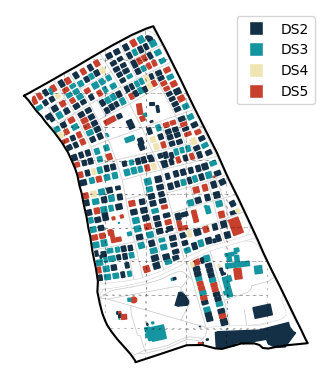

In [53]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_damage_states_buildings(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()

    # create legend
    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D'
    legend_elements = [
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize='10', label='DS2'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize='10', label='DS3'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize='10', label='DS4'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#C7402D', markersize='10', label='DS5')
    ]

    # add legend to graph
    ax.legend(handles=legend_elements, loc='upper right')

    for a in areas:
        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")        

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            if a.buildings[i].damage_state == 'DS2':
                c = '#133046'
            elif a.buildings[i].damage_state == 'DS3':
                c = '#15959F'
            elif a.buildings[i].damage_state == 'DS4':
                c = '#F1E4B3'
            else:
                c = '#C7402D'
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    fig.savefig('images/damage_states.png', dpi=300)
    plt.show()

# show the geometry for each area, sub_area and building
show_damage_states_buildings([area])

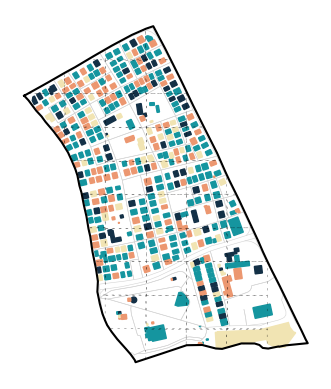

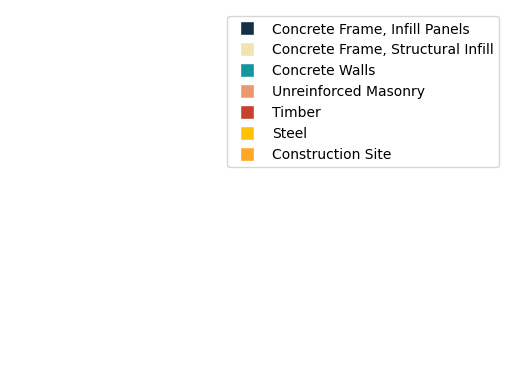

In [54]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_structural_system_buildings(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()

    # create legend
    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D', '#D3D3D3'
    legend_fig, legend_ax = plt.subplots()
    legend_elements = [
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize='10', label='Concrete Frame, Infill Panels'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize='10', label='Concrete Frame, Structural Infill'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize='10', label='Concrete Walls'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#EC9770', markersize='10', label='Unreinforced Masonry'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#C7402D', markersize='10', label='Timber'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#FFC107', markersize='10', label='Steel'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#FFA726', markersize='10', label='Construction Site'),
    ]

    # add legend to graph
    legend_ax.legend(handles=legend_elements, loc='upper right')

    for a in areas:
        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")        

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            if a.buildings[i].building_typology == 'Concrete Frame, Infill Panels':
                c = '#133046'
            elif a.buildings[i].building_typology == 'Concrete Frame, Structural Infill':
                c = '#F1E4B3'
            elif a.buildings[i].building_typology == 'Concrete Walls':
                c = '#15959F'
            elif a.buildings[i].building_typology == 'Unreinforced Masonry':
                c = '#EC9770'                
            elif a.buildings[i].building_typology == 'Timber':
                c = '#C7402D'       
            elif a.buildings[i].building_typology == 'Steel':
                c = '#FFC107'  
            elif a.buildings[i].building_typology == 'Construction Site':
                c = '#FFA726'                                                 
            else:
                c = '#D3D3D3'
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    ax.axis('off')    
    fig.savefig('images/structural_systems.png', dpi=300)
    legend_fig.savefig('images/structural_systems_legend.png', dpi=300)
    plt.show()

# show the geometry for each area, sub_area and building
show_structural_system_buildings([area])

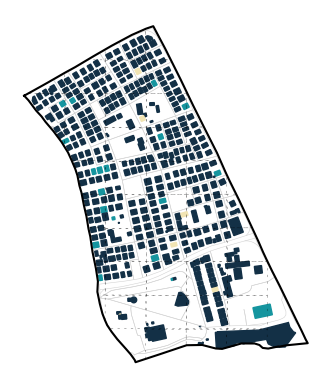

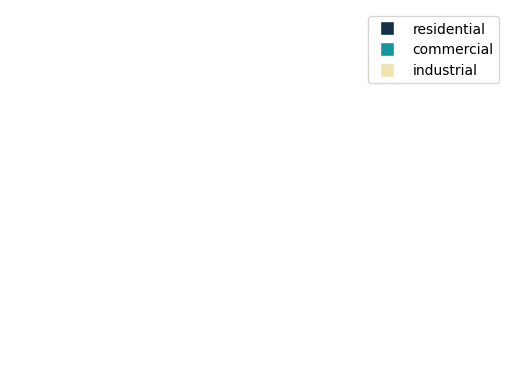

In [55]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_occupancy_type_buildings(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()

    # create legend
    # '#133046', '#15959F', '#F1E4B3', '#EC9770', '#C7402D', '#D3D3D3'
    legend_fig, legend_ax = plt.subplots()
    legend_elements = [
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#133046', markersize='10', label='residential'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#15959F', markersize='10', label='commercial'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#F1E4B3', markersize='10', label='industrial'),
    ]

    # add legend to graph
    legend_ax.legend(handles=legend_elements, loc='upper right')

    for a in areas:
        # Plot the network in the area
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")        

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha = 0.5, linewidth=0.4, linestyle=(0, (4, 8)))
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for i, g in enumerate(geos):
            if a.buildings[i].occupancy_type == 'residential':
                c = '#133046'
            elif a.buildings[i].occupancy_type == 'commercial':
                c = '#15959F'
            elif a.buildings[i].occupancy_type == 'industrial':
                c = '#F1E4B3'                                               
            else:
                c = '#D3D3D3'
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    # ax.set_aspect('equal')
    plt.axis('off')
    ax.axis('off')    
    fig.savefig('images/occupancy_type.png', dpi=300)
    legend_fig.savefig('images/occupancy_type_legend.png', dpi=300)
    plt.show()

# show the geometry for each area, sub_area and building
show_occupancy_type_buildings([area])

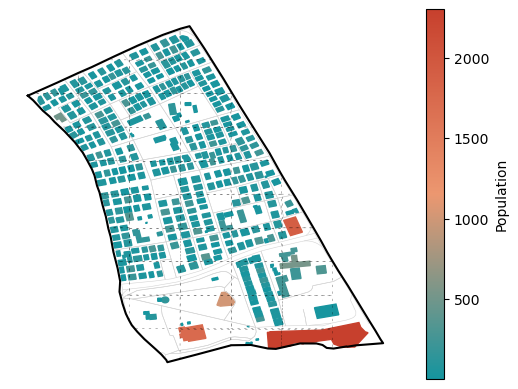

In [56]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define a function which plots the geometry of the areas, sub-areas, and buildings
def show_population_night_buildings(areas):
    # Create an empty figure and axes
    fig, ax = plt.subplots()

    # Create a legend figure and axes
    # legend_fig, legend_ax = plt.subplots()

    # Define a color map for the population gradient
    cmap = LinearSegmentedColormap.from_list("population", ['#15959F', '#EC9770', '#C7402D'], N=256)

    for a in areas:
        # Plot the network in the area
        # Note: It seems like "network_gdf" is used here, but it should be defined or imported somewhere in your code.
        # You may need to replace this with your actual network data.
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # Plot the sub-area geometry
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha=0.5, linewidth=0.4, linestyle=(0, (4, 8)))

        # Plot the building geometry with population gradient
        populations = [building.population_night for building in a.buildings]
        norm = plt.Normalize(min(populations), max(populations))
        colors = cmap(norm(populations))
        
        for i, building in enumerate(a.buildings):
            x, y = building.geometry.exterior.xy
            ax.fill(x, y, color=colors[i])

    # Create a colorbar for the population gradient
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Population')

    # Customize the plot
    ax.set_aspect('equal')
    ax.axis('off')

    # Save the figure with a higher resolution
    fig.savefig('images/population_night.png', dpi=300)

    # Display the plot
    plt.show()

# Call the function with the list of areas
show_population_night_buildings([area])

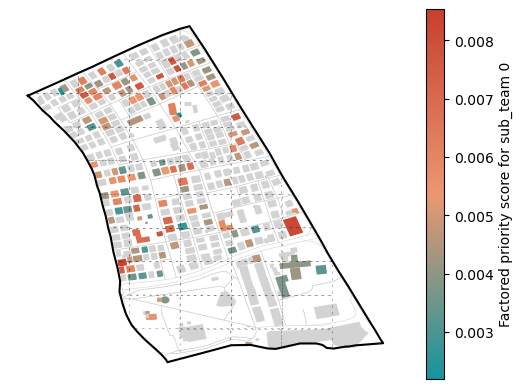

In [68]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_priority_score_buildings(areas, sub_team):
    # Create an empty figure and axes
    fig, ax = plt.subplots()

    # Create a legend figure and axes
    # legend_fig, legend_ax = plt.subplots()

    # Define a color map for the population gradient
    cmap = LinearSegmentedColormap.from_list('Priority score for sub_team '+str(sub_team.sub_team_id), ['#15959F', '#EC9770', '#C7402D'], N=256)

    for a in areas:
        # Plot the network in the area
        # Note: It seems like "network_gdf" is used here, but it should be defined or imported somewhere in your code.
        # You may need to replace this with your actual network data.
        network_gdf.plot(ax=ax, linewidth=0.4, edgecolor="#D3D3D3")

        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y, 'black')  # You can set a specific color

        # Plot the sub-area geometry
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy, 'black', alpha=0.5, linewidth=0.4, linestyle=(0, (4, 8)))

        # Plot the building geometry with population gradient
        priority_scores = list(sub_team.serveable_buildings.values())
        norm = plt.Normalize(min(priority_scores), max(priority_scores))
        
        for i, building in enumerate(a.buildings):
            x, y = building.geometry.exterior.xy
            if building in sub_team.serveable_buildings.keys():
                colors = cmap(norm(sub_team.serveable_buildings[building]))
            else:
                colors = '#D3D3D3'
            ax.fill(x, y, color=colors)

    # Create a colorbar for the population gradient
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Factored priority score for sub_team '+str(sub_team.sub_team_id))

    # Customize the plot
    ax.set_aspect('equal')
    ax.axis('off')

    # Save the figure with a higher resolution
    fig.savefig('images/priority_score.png', dpi=300)

    # Display the plot
    plt.show()

# show the geometry for each area, sub_area and building
show_priority_score_buildings([area], sub_teams[0])

In [ ]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsCurve("Footprints", "F", "List of footprints imported"),
             hs.HopsNumber("Injuries", "I", "List of injuries per building"),
             hs.HopsString("Structural system", "SS", "List of structural system per building"),
             hs.HopsNumber("Damage state probabilities", "DSP", "List of damage state probabilities per building"),
             hs.HopsString("Occupancy type", "OT", "List of occupancy type per building"),
             hs.HopsNumber("Building ID", "BID", "List of building ID per building")
             ]
)

def import_footprints():
    # geos = [o.geometry for o in area.buildings]
    # injuries = [o.injuries for o in area.buildings]
    # injuries_int = [round(injury) for injury_list in injuries for injury in injury_list]
    # structural_system = [o.structural_system for o in area.buildings]
    # damage_state_probabilities = [o.damage_state_probabilities for o in area.buildings]
    # damage_state_probabilities = [item for sublist in damage_state_probabilities for item in sublist]
    # occupancy_type = [o.occupancy_type for o in area.buildings]
    # building_id = [int(o.building_id) for o in area.buildings]

    geos = [o.geometry for o in area.sub_areas[22].buildings]
    injuries = [o.injuries for o in area.sub_areas[22].buildings]
    injuries_int = [round(injury) for injury_list in injuries for injury in injury_list]
    structural_system = [o.structural_system for o in area.sub_areas[22].buildings]
    damage_state_probabilities = [o.damage_state_probabilities for o in area.sub_areas[22].buildings]
    damage_state_probabilities = [item for sublist in damage_state_probabilities for item in sublist]
    occupancy_type = [o.occupancy_type for o in area.sub_areas[22].buildings]
    building_id = [int(o.building_id) for o in area.sub_areas[22].buildings]

    polygons = []
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
        polygon = rs.Curve.CreateControlPointCurve(points, 1)
        polygons.append(polygon)
    return polygons, injuries_int, structural_system, damage_state_probabilities, occupancy_type, building_id

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[INFO] 127.0.0.1 - - [06/Nov/2023 14:43:13] "GET /imft HTTP/1.1" 200 -
[INFO] 127.0.0.1 - - [06/Nov/2023 14:43:13] "GET /imft HTTP/1.1" 200 -
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14e823acd60>
[INFO] Solving using legacy API: <HopsComponent /imft [ -> ImportFootprints -> Footprints,Injuries,Structural system,Damage state probabilities,Occupancy type,Building ID] >
[INFO] 127.0.0.1 - - [06/Nov/2023 14:43:13] "POST /solve HTTP/1.1" 200 -
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14e823acee0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14e823ace20>


In [70]:
import rhino3dm as rs

injuries = [o.injuries for o in area.sub_areas[0].buildings]
injuries_int = [round(injury) for injury_list in injuries for injury in injury_list]
print(len(injuries))
print(injuries_int)
structural_system = [o.structural_system for o in area.buildings]
print(structural_system)
occupancy_type = [o.occupancy_type for o in area.buildings]
print(occupancy_type)
building_id = [o.building_id for o in area.buildings]
print(building_id)
priority_scores = sub_teams[0].serveable_buildings
print(priority_scores)
priority_scores = list(sub_teams[0].serveable_buildings.values())
print(priority_scores)
print(areas)

2
[51, 31, 15, 4, 7, 36, 3, 1, 0, 1]
['CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'MUR', 'MUR', 'MUR', 'MUR', 'CR', 'CR', 'MUR', 'CR', 'MUR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'MUR', 'CR', 'MUR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'MUR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'MUR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'MUR', 'CR', 'CR', 'MUR', 'CR', 'MUR',